In [46]:
from myclasses.sql_executor import SQLExecutor
import pandas as pd

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT 
            gross_revenue,
            fiscal_year,
            ownership,
            -- tot_days,
            -- tot_days_title_v,
            -- tot_days_title_xviii,
            -- tot_days_title_xix,
            -- num_beds,
            -- tot_bed_days_avail,
            -- snf_num_beds,
            -- snf_admis_tot,
            -- snf_avg_stay_len_title_tot,
            -- snf_days_total,
            -- tot_discharge_tot,
            -- snf_discharge_tot,
            -- tot_salaries,
            -- overhead_nonsalary_costs,
            -- cash,
            -- acct_rec,
            -- acct_payable,
            -- tot_current_assets,
            -- tot_fixed_assets,
            -- tot_assets,
            -- tot_liabilities,
            -- contract_labor,
            -- total_operating_expense,
            loc_type,
            current_ratio,
            deficiency_score,
            overall_rating,
            county_ssa,
            zip,
            resfamcouncil,
            sprinkler_status,
            chow_last_12mos,
            fine_cnt,
            fine_tot,
            tot_penlty_cnt,
            state,
            survey_rating,
            quality_rating,
            staffing_rating,
            rn_staffing_rating,
            aidhrd,
            vochrd,
            rnhrd,
            totlichrd,
            tothrd,
            pthrd,
            weighted_all_cycles_score,
            certification,
            bedcert,
            region,
            snf_size

        FROM Master
        ORDER BY prov_id;
        """

    # Execute the query and get the result as a DataFrame
    df = sql_executor.execute_query(query)

In [47]:
from sklearn.model_selection import train_test_split

# Select columns where data type is text (object)
text_columns = df.select_dtypes(include=['object']).columns

# Create dummy variables for text columns
df_encoded = pd.get_dummies(df, columns=text_columns)

# Convert all columns to numeric type
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Extract target variable (y) and independent variables (X)
y = df_encoded['gross_revenue']
X = df_encoded.iloc[:, 2:]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
import xgboost as xgb

# Define XGBoost regressor and set hyperparameters
xgb_model = xgb.XGBRegressor(
    n_estimators=3000,      # Iterations of the model
    learning_rate=0.005,    # Speed at which the learners optimize
    max_depth=9,            # Depth of the weak learners
    min_child_weight=1,
    subsample=0.85,
    colsample_bytree=0.95,
    random_state=42,
    eval_metric='rmse',
    objective='reg:squarederror',
    gamma=0.15,              # Increasing this value will make model more conservative
    reg_alpha=0.19,           # Increasing this value will make model more conservative
    reg_lambda=0.09          # Increasing this value will make model more conservative
)

# Train the model with progress printout and early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluation set for tracking progress
)

[0]	validation_0-rmse:5880784.95940	validation_1-rmse:6074672.07863
[1]	validation_0-rmse:5859781.17409	validation_1-rmse:6055459.33620
[2]	validation_0-rmse:5838746.56658	validation_1-rmse:6035789.09730
[3]	validation_0-rmse:5817994.91163	validation_1-rmse:6016510.00887
[4]	validation_0-rmse:5797424.59832	validation_1-rmse:5997618.28018
[5]	validation_0-rmse:5776781.43369	validation_1-rmse:5978630.72606
[6]	validation_0-rmse:5756195.33575	validation_1-rmse:5959852.37231
[7]	validation_0-rmse:5736039.29609	validation_1-rmse:5941297.69925
[8]	validation_0-rmse:5717951.50916	validation_1-rmse:5924654.33966
[9]	validation_0-rmse:5698032.26315	validation_1-rmse:5905944.86737
[10]	validation_0-rmse:5678115.35886	validation_1-rmse:5887581.89360
[11]	validation_0-rmse:5658375.94027	validation_1-rmse:5869544.28652
[12]	validation_0-rmse:5638825.17875	validation_1-rmse:5851503.87199
[13]	validation_0-rmse:5619135.38086	validation_1-rmse:5833609.46505
[14]	validation_0-rmse:5599631.36467	validat

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, median_absolute_error, max_error, mean_absolute_error, mean_squared_error, explained_variance_score

# Predict on test set
y_pred = xgb_model.predict(X_test)

# R² Score (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

# Median Absolute Error
mdae = median_absolute_error(y_test, y_pred)

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Root Mean Squared Error: ${:.2f}".format(rmse))
print("Median Absolute Error: ${:.2f}".format(mdae))
print("Mean Absolute Error: ${:.2f}".format(mae))
print("Mean Absolute Percentage Error: {:.2f}%".format(mape))
print("R² Score (Coefficient of Determination): {:.5f}".format(r2))
# ADD VIF

Root Mean Squared Error: $2768170.10
Median Absolute Error: $1106792.50
Mean Absolute Error: $1670994.78
Mean Absolute Percentage Error: 18.29%
R² Score (Coefficient of Determination): 0.79156


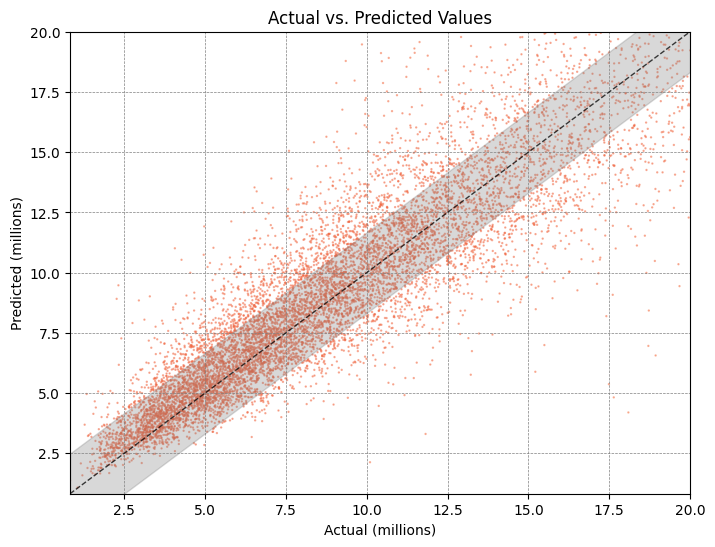

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert values to millions
y_test_millions = y_test / 1000000
y_pred_millions = y_pred / 1000000
median_absolute_error_millions = mae / 1000000

# Calculate residuals
residuals = y_pred_millions - y_test_millions

# Define colors based on residuals
norm = plt.Normalize(residuals.min(), 400)
colors = plt.cm.RdYlGn(norm(np.abs(residuals)))

plt.figure(figsize=(8, 6))
plt.scatter(y_test_millions, y_pred_millions, c=colors, alpha=0.5, s=0.5)
plt.plot([y_test_millions.min(), y_test_millions.max()], [y_test_millions.min(), y_test_millions.max()], 'k--', lw=1, alpha=0.75)  # Plot the diagonal line
plt.xlabel('Actual (millions)')
plt.ylabel('Predicted (millions)')
plt.title('Actual vs. Predicted Values')

# Set axis limits to show the actual values
plt.xlim(left=y_test_millions.min(), right=20)
plt.ylim(bottom=y_test_millions.min(), top=20)

# Add light gridlines
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Add shaded lines for Median Absolute error
actual_min = y_test_millions.min()
actual_max = 20
cone_x = np.linspace(actual_min, actual_max, 100)
cone_y_upper = cone_x + median_absolute_error_millions
cone_y_lower = cone_x - median_absolute_error_millions
plt.fill_between(cone_x, cone_y_lower, cone_y_upper, color='grey', alpha=0.3)

plt.show()


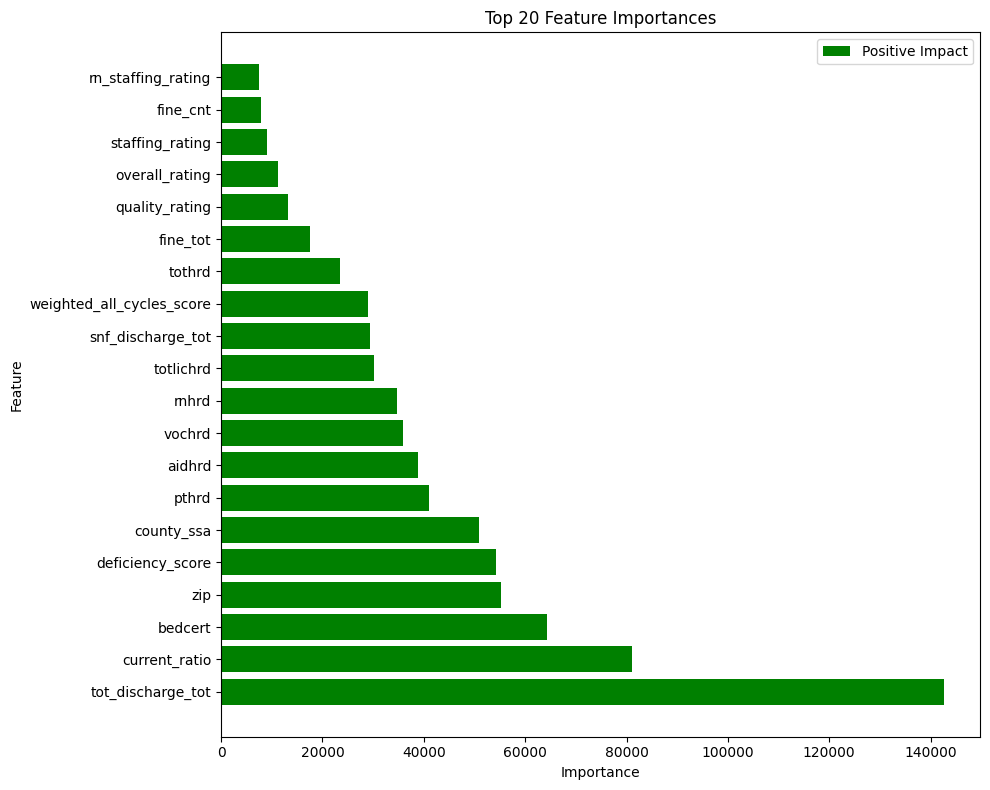

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances based on gain
feature_importances_gain = xgb_model.get_booster().get_score()

# Sort the dictionary by importances in descending order
sorted_feature_importance_gain = sorted(feature_importances_gain.items(), key=lambda x: x[1], reverse=True)

# Separate positive and negative importances (since gain is inherently positive)
positive_importances_gain = dict(sorted_feature_importance_gain)

# Extract feature names and importances
positive_features_gain, positive_importances_gain = zip(*positive_importances_gain.items())

# Select only the top 20 features
top_features_gain = positive_features_gain[:20]
top_importances_gain = positive_importances_gain[:20]

# Plot positive importances based on gain for top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_features_gain, top_importances_gain, color='green', label='Positive Impact')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Text(0.5, 1.0, 'XGBoost Learning Curve with rmse')

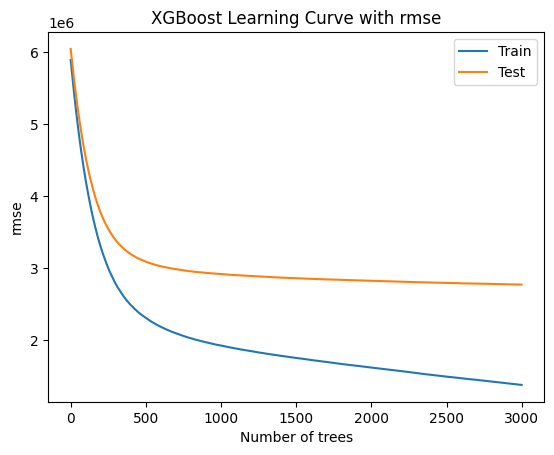

In [ ]:
# Get the evaluation results
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot the learning curve with RSME
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('rmse')
plt.title('XGBoost Learning Curve with rmse')